In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [10]:
data = pd.read_csv("fix_flags.bc.20180619-231106.csv", header=None, names=["Benchmark", "Flags", "Energy", "Time"])
data.head()

,Benchmark,Flags,Energy,Time
0,mg.D.x,-O0,40574711131,199.733609
1,mg.D.x,-O0,40889374449,196.799768
2,mg.D.x,-O0,41144025286,199.766007
3,ft.B.x,-O0,1260705024,6.314070
4,ft.B.x,-O0,1242152522,6.108455


In [32]:
no_o0 = data[data["Flags"] != "-O0"]

In [24]:
print(data["Benchmark"].unique())

['mg.D.x' 'ft.B.x' 'bt.C.x' 'lu.B.x' 'sp.B.x' 'ep.D.x' 'ua.B.x' 'is.B.x'
 'cg.C.x']


In [20]:
def plot_results(data):
    benchmarks = data["Benchmark"].unique()
    num_benchmarks = len(benchmarks)

    cmap = get_cmap(num_benchmarks)

    for index, row in data.iterrows():
        marker = "x"
        if row["Flags"] == "-O0":
            marker = "x"
        elif row["Flags"] == "-O1":
            marker = "o"
        elif row["Flags"] == "-O2":
            marker = "v"
        elif row["Flags"] == "-O3":
            marker = "*"

        plt.scatter(row["Time"], row["Energy"], marker=marker, c=cmap(index))

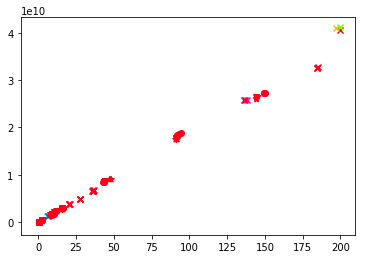

In [21]:
plot_results(data)

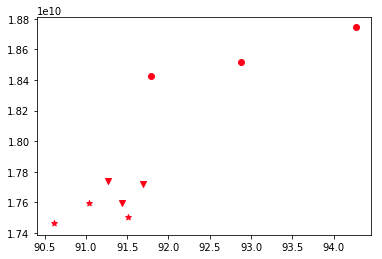

In [33]:
plot_results(no_o0[no_o0["Benchmark"] == "mg.D.x"])

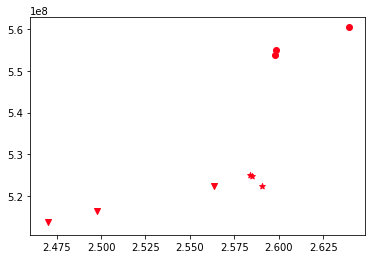

In [34]:
plot_results(no_o0[no_o0["Benchmark"] == "ft.B.x"])

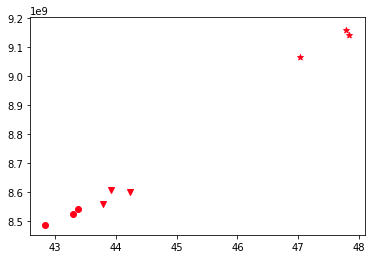

In [35]:
plot_results(no_o0[no_o0["Benchmark"] == "bt.C.x"])

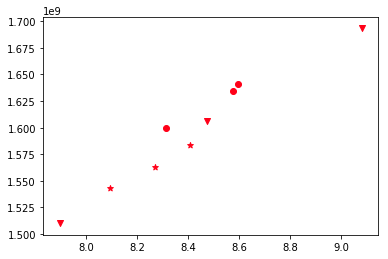

In [36]:
plot_results(no_o0[no_o0["Benchmark"] == "lu.B.x"])

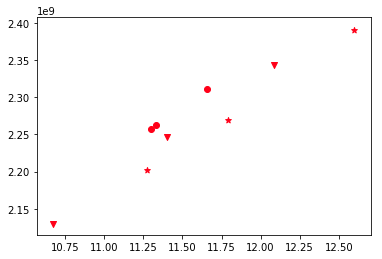

In [37]:
plot_results(no_o0[no_o0["Benchmark"] == "sp.B.x"])

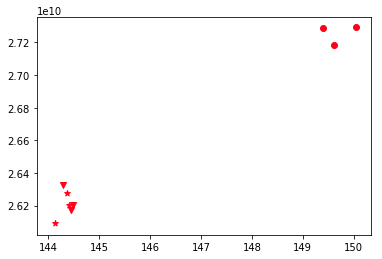

In [38]:
plot_results(no_o0[no_o0["Benchmark"] == "ep.D.x"])

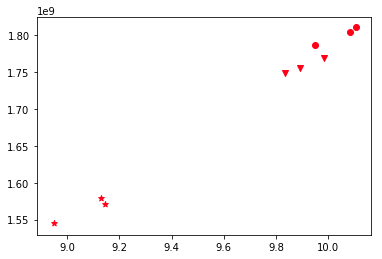

In [39]:
plot_results(no_o0[no_o0["Benchmark"] == "ua.B.x"])

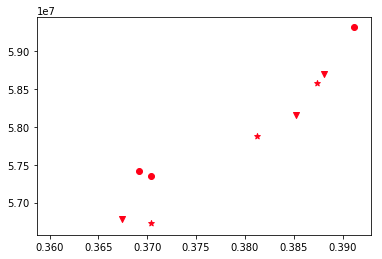

In [40]:
plot_results(no_o0[no_o0["Benchmark"] == "is.B.x"])

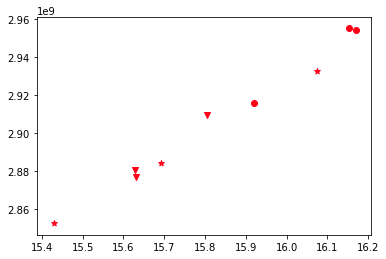

In [41]:
plot_results(no_o0[no_o0["Benchmark"] == "cg.C.x"])